# Работа 2. Фильтр частиц (вариант 11)

## 1. Тестовые входные сигналы

In [1]:
import random
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [13]:
def diff(f, dt):
    df = np.diff(f) / dt
    df = np.append(df, df[-1])
    return df

def test_model_circle(noise_val):
    # задаём временной интервал и шаг дискретизации
    T, dt = 40, 0.05
    t = np.arange(0, T, dt)
    # считаем скорость квадрокоптера примерно равной 25 м/с;
    # радиус траектории - 100 м; радиус Земли - примерно 6400 км
    v, r, R_Earth = 25, 100, 6400000
    # задаём центр траектории (окружности)
    phi_0, theta_0 = 90, 0
    # т.к. при малых углах sinx~x, можем так записать движение по окружности
    phi = phi_0 + 180/np.pi * r * np.cos(v/r * t) / R_Earth
    theta = theta_0 + 180/np.pi * r * np.sin(v/r * t) / R_Earth
    # вычисляем первые и вторые производные
    dphi, dtheta = diff(phi, dt), diff(theta, dt)
    ddphi, ddtheta = diff(dphi, dt), diff(dtheta, dt)
    # создаём матрицу, содержащую состояния во все моменты времени
    Z = np.zeros((6, len(t)))
    Z[0], Z[1], Z[2], Z[3], Z[4], Z[5] = phi, theta, dphi, dtheta, ddphi, ddtheta
    # создаём матрицу, содержащую измерения во все моменты времени
    Y = np.zeros((2, len(t)))
    Y[0], Y[1] = ddphi, ddtheta
    # добавляем шум в измерения
    R = 90/np.pi * v**2 / r / R_Earth * np.diag(noise_val)
    Y_noise = np.zeros(Y.shape)
    Y_noise[0] = Y[0] + np.random.normal(0, R[0][0], Y[0].shape)
    Y_noise[1] = Y[1] + np.random.normal(0, R[1][1], Y[1].shape)
    # определим случайные отклонения
    S = 90/np.pi * v**2 / r / R_Earth
    random_shifts_devs = S * np.array([(r/v)**2, 
                                       (r/v)**2, 
                                       r/v, 
                                       r/v, 
                                       1, 
                                       1])
    # масштабирование
    scales = np.array([[1.], [1.]])
    return t, Z, Y, Y_noise, random_shifts_devs, scales

def test_model_spiral(noise_val):
    # задаём временной интервал и шаг дискретизации
    T, dt = 40, 0.05
    t = np.arange(0, T, dt)
    # считаем скорость квадрокоптера в начальный момент времени
    # по касательной - 15 м/с, в радиальном направлении - 10 м/с;
    # начальный радиус траектории - 75 м; радиус Земли - примерно 6400 км
    v_r, v_tan, r_0, R_Earth = 10, 15, 75, 6400000
    # задаём центр траектории (спирали)
    phi_0, theta_0 = 90, 0
    # т.к. при малых углах sinx~x, можем так записать движение по спирали
    phi = phi_0 + 180/np.pi * (r_0 + v_r * t) * np.cos(v_tan/r_0 * t) / R_Earth
    theta = theta_0 + 180/np.pi * (r_0 + v_r * t) * np.sin(v_tan/r_0 * t) / R_Earth
    # вычисляем первые и вторые производные
    dphi, dtheta = diff(phi, dt), diff(theta, dt)
    ddphi, ddtheta = diff(dphi, dt), diff(dtheta, dt)
    # создаём матрицу, содержащую состояния во все моменты времени
    Z = np.zeros((6, len(t)))
    Z[0], Z[1], Z[2], Z[3], Z[4], Z[5] = phi, theta, dphi, dtheta, ddphi, ddtheta
    # создаём матрицу, содержащую измерения во все моменты времени
    Y = np.zeros((2, len(t)))
    Y[0], Y[1] = ddphi, ddtheta
    # добавляем шум в измерения
    R = 90/np.pi * (v_tan**2 + v_r**2) / r_0 / R_Earth * np.diag(noise_val)
    Y_noise = np.zeros(Y.shape)
    Y_noise[0] = Y[0] + np.random.normal(0, R[0][0], Y[0].shape)
    Y_noise[1] = Y[1] + np.random.normal(0, R[1][1], Y[1].shape)
    # определим случайные отклонения
    S = 90/np.pi * (v_tan**2 + v_r**2) / r_0 / R_Earth
    random_shifts_devs = S * np.array([(r_0/v_tan)**2, 
                                       (r_0/v_tan)**2, 
                                       r_0/v_tan, 
                                       r_0/v_tan, 
                                       1, 
                                       1])
    # масштабирование
    scales = np.array([[1.], [1.]])
    return t, Z, Y, Y_noise, random_shifts_devs, scales

def test_model_sin(noise_val):
    # задаём временной интервал и шаг дискретизации
    T, dt = 40, 0.05
    t = np.arange(0, T, dt)
    # считаем скорость квадрокоптера по экватору - 15 м/с,
    # средняя скорость вдоль меридиана ~ 10 м/с;
    # максимальное отклонение от экватора - 75 м; радиус Земли - примерно 6400 км
    v_e, v_m, r, R_Earth = 15, 15, 75, 6400000
    # задаём начальное положение
    phi_0, theta_0 = 90, 0
    # т.к. при малых углах sinx~x, можем так записать уравнение движения
    phi = phi_0 + 180/np.pi * v_m * t / R_Earth
    theta = theta_0 + 180/np.pi * r * np.sin(v_e/r * t) / R_Earth
    # вычисляем первые и вторые производные
    dphi, dtheta = diff(phi, dt), diff(theta, dt)
    ddphi, ddtheta = diff(dphi, dt), diff(dtheta, dt)
    # создаём матрицу, содержащую состояния во все моменты времени
    Z = np.zeros((6, len(t)))
    Z[0], Z[1], Z[2], Z[3], Z[4], Z[5] = phi, theta, dphi, dtheta, ddphi, ddtheta
    # создаём матрицу, содержащую измерения во все моменты времени
    Y = np.zeros((2, len(t)))
    Y[0], Y[1] = ddphi, ddtheta
    # добавляем шум в измерения
    R = 90/np.pi * v_e**2 / r / R_Earth * np.diag(noise_val)
    Y_noise = np.zeros(Y.shape)
    Y_noise[0] = Y[0] + np.random.normal(0, R[0][0], Y[0].shape)
    Y_noise[1] = Y[1] + np.random.normal(0, R[1][1], Y[1].shape)
    # определим случайные отклонения
    S = 90/np.pi * v_e**2 / r / R_Earth
    random_shifts_devs = S * np.array([(r/v_e)**2, 
                                       (r/v_e)**2, 
                                       r/v_e, 
                                       r/v_e, 
                                       1, 
                                       1])
    # масштабирование
    scales = np.array([[1.], [1.]])
    return t, Z, Y, Y_noise, random_shifts_devs, scales

## 2. Фильтр частиц

In [3]:
def F_linear(dt):
    return np.array([[1, 0, dt, 0, dt**2 / 2, 0],
                     [0, 1, 0, dt, 0, dt**2 / 2],
                     [0, 0, 1, 0, dt, 0],
                     [0, 0, 0, 1, 0, dt],
                     [0, 0, 0, 0, 1, 0],
                     [0, 0, 0, 0, 0, 1]])

def H_linear():
    return np.array([[0, 0, 0, 0, 1, 0],
                     [0, 0, 0, 0, 0, 1]])

def gaussian(x, mean, dev):
    return np.exp(-0.5 * (x - mean)**2 / dev**2) / (dev * (2 * np.pi)**0.5)

def resampling(weights, particles):
    """ функция для отбора точек из списка points
     для следующей итерации по их весам weights """
    # общее число точек
    if len(weights) != particles.shape[1]:
        return []
    NP = len(weights)
    # выбираем случайную исходную точку  для перебора в интервале [0, 1]
    curr_level = random.random() / NP
    # разница между выбираемыми точками
    level_diff = 1. / NP
    # создаём список номеров выбранных точек
    chosen_points = [None] * NP
    current_point = 0
    current_sum = weights[0]
    for check_point in range(NP):
        # пропускаем входные точки, пока 
        # не достигнут уровень выбираемой точки
        while current_sum < curr_level:
            current_sum += weights[current_point+1]
            current_point += 1
        # уровень очередной точки достигнут;
        # отбираем её номер в итоговую выборку
        chosen_points[check_point] = current_point
        curr_level += level_diff
    # заполняем новую выборку 
    # точками с выбранными номерами
    new_particles = np.zeros(particles.shape)
    for i in range(new_particles.shape[1]):
        new_particles[:, i] = particles[:, chosen_points[i]]
    return new_particles

def particle_step(y, particles, dt, scales, random_shifts_devs):
    # контейнеры для результатов
    new_particles = np.zeros(particles.shape)
    weights = np.zeros(particles.shape[1])
    # задаём матрицы системы
    F = F_linear(dt)
    H = H_linear()
    # для каждой частицы
    for i in range(particles.shape[1]):
        # рассчитаем новое состояние системы по уравнению состояния
        new_z = F @ particles[:, i]
        # рассчитаем, какие показания должны быть получены 
        # в этом новом состоянии
        y_est = H @ new_z
        # рассчитаем евклидово расстояние между оценкой и реальными показаниями Y;
        # так как переменные вектора состояния имеют разные размерности и разный физический смысл,
        # желательно для улучшения качества фильтрации изменить метод расчёта этой меры различия,
        # чтобы учитывать различия масштабов
        dist = np.sum(((y - y_est) @ scales) ** 2)
        # рассчитаем достоверность оценки (используем для этого такую 
        # функцию, чтобы при малых dist она была близка к 1, при больших к 0;
        # конкретные параметры этой функции чаще всего подбираются под данные):
        weights[i] = gaussian(dist, 0, 1)
        # сохраняем результат
        new_particles[:, i] = new_z
    # нормализуем веса
    weights = weights / np.sum(weights)
    weights.reshape((1, particles.shape[1]))
    # оценим текущее состояние как взвешенное среднее полученных частиц
    z_weighted = np.sum(new_particles * weights, axis=1)
    # отберём частицы в соответствии с весами
    new_particles = resampling(weights, new_particles)
    # выполним рандомизацию полученных частиц, чтобы дать системе адаптироваться
    # к ошибкам входных данных
    for i in range(new_particles.shape[1]):
        new_particles[:, i] += (np.random.randn(new_particles.shape[0]) * 
                                random_shifts_devs)
    # выдадим новую оценку и новый набор частиц
    return z_weighted, new_particles

def generate_particles(limits, p_num):
    """ создать облако из p_num частиц формата numpy.array
    с равномерно распределёнными значениями,
    лежащими между указанными в limits пределами"""
    # размер одной частицы
    p_len = len(limits)
    # матрицы пределов
    mins = limits[:, 0]
    maxs = limits[:, 1]
    # генерация
    res = np.zeros((p_len, p_num))
    for i in range(p_num):
        v = np.random.rand(p_len)
        res[:, i] = mins * v + maxs * (1 - v)
    return res

def particle(z0, z_limits, pnum, Y, dt, scales, random_shifts_devs):
    """
    z0 --- numpy-array размером N x 1; начальное состояние системы
    z_limits --- список длины N с парами (минимум, максимум), обозначающими границы
      начальной оценки каждой переменной состояния
    pnum --- число используемых частиц
    Y --- матрица, содержащая выход системы во все моменты времени
    dt --- float, шаг моделирования
    scales --- numpy-array размера Mx1; масштабные коэффициенты для измерения различия
      реального и оцениваемого выходов системы
    random_shifts_devs --- numpy-array размера N x 1; среднеквадратические отклонения
      для рандомизации частиц с целью повышения адаптивности системы к ошибкам
    """
    # подготовим матрицу для результата
    Z_res = np.zeros((len(z0), Y.shape[1]))
    Z_res[:, 0] = z0
    # создадим начальный вариант частиц
    particles = generate_particles(z_limits, pnum)
    # вычислим состояния последовательно
    for i in range(1, Y.shape[1]):
        z, particles = particle_step(Y[:, i], particles, dt, scales, random_shifts_devs)
        Z_res[:, i] = z
    return Z_res

## 3. Проверка работы фильтра

In [4]:
def show(t, Z, Y, pnum, scales, random_shifts_devs):
    dt = t[1] - t[0]
    z0 = Z[:, 0]
    z_limits = np.zeros((len(z0), 2))
    z_limits[:, 0] = z0 - random_shifts_devs
    z_limits[:, 0] = z0 + random_shifts_devs
    Z_filtered = particle(z0, z_limits, pnum, Y, dt, scales, random_shifts_devs)
    plt.title("Quadrocopter positions") 
    plt.xlabel("lon") 
    plt.ylabel("lat") 
    # точное положение
    plt.plot(Z[0], Z[1], color='r') 
    # оценка по показаниям приборов
    plt.plot(Z_filtered[0], Z_filtered[1], color='g')
    plt.show()
    
    plt.title("Quadrocopter speed") 
    plt.xlabel("dlon/dt") 
    plt.ylabel("dlat/dt") 
    # точная скорость
    plt.plot(Z[2], Z[3], color='r') 
    # оценка по показаниям приборов
    plt.plot(Z_filtered[2], Z_filtered[3], color='g')
    plt.show()

## Чистые данные

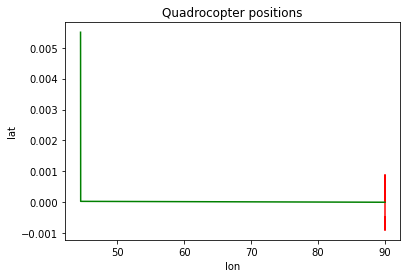

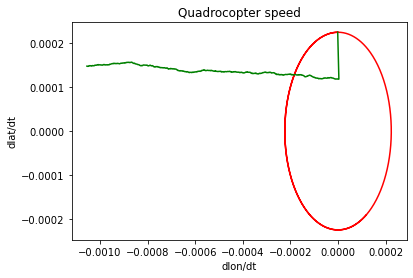

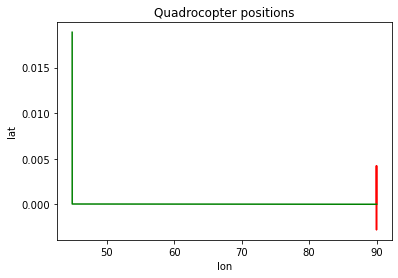

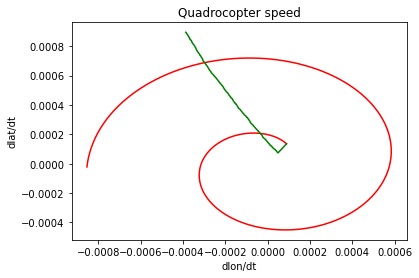

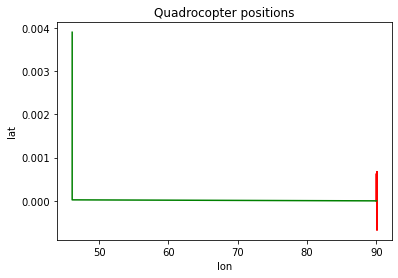

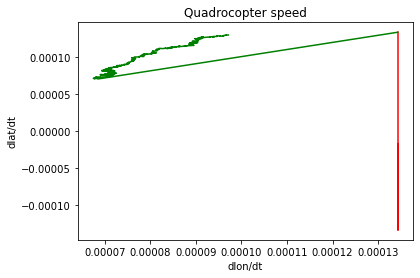

In [19]:
noise_val = [0.1, 0.1]
pnum = 1000
mult = 0.1

# окружность
t, Z, Y, Y_noise, random_shifts_devs, scales = test_model_circle(noise_val)
show(t, Z, Y, pnum, scales, mult * random_shifts_devs)

# спираль
t, Z, Y, Y_noise, random_shifts_devs, scales = test_model_spiral(noise_val)
show(t, Z, Y, pnum, scales, mult * random_shifts_devs)

# синусоида
t, Z, Y, Y_noise, random_shifts_devs, scales = test_model_sin(noise_val)
show(t, Z, Y, pnum, scales, mult * random_shifts_devs)

## Зашумлённые данные

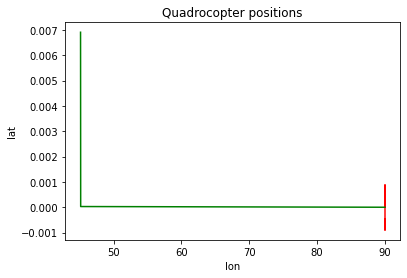

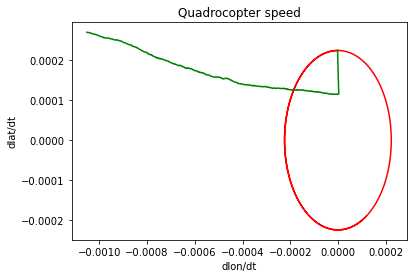

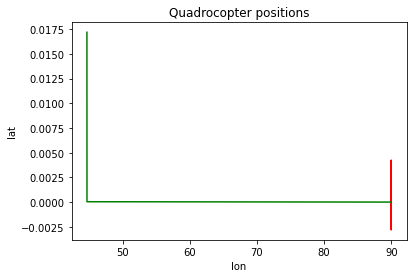

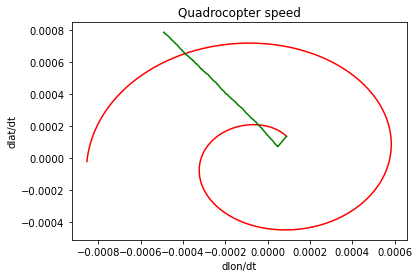

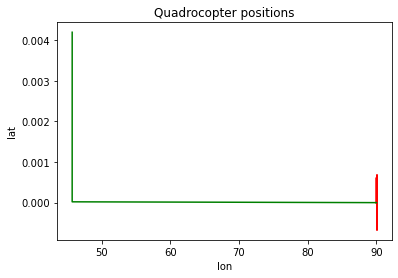

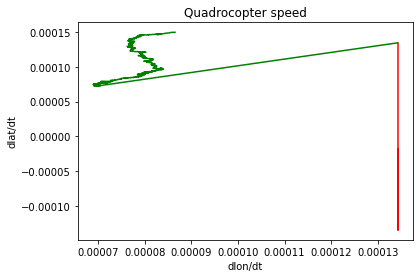

In [20]:
noise_val = [0.1, 0.1]
pnum = 1000
mult = 0.1

# окружность
t, Z, Y, Y_noise, random_shifts_devs, scales = test_model_circle(noise_val)
show(t, Z, Y_noise, pnum, scales, mult * random_shifts_devs)

# спираль
t, Z, Y, Y_noise, random_shifts_devs, scales = test_model_spiral(noise_val)
show(t, Z, Y_noise, pnum, scales, mult * random_shifts_devs)

# синусоида
t, Z, Y, Y_noise, random_shifts_devs, scales = test_model_sin(noise_val)
show(t, Z, Y_noise, pnum, scales, mult * random_shifts_devs)

## 4. Реакция фильтра на изменение шума
### Шум измерений

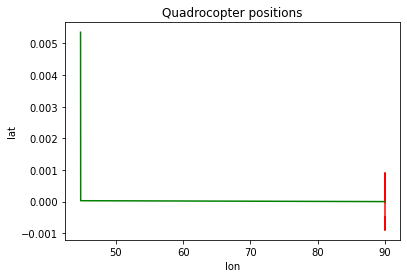

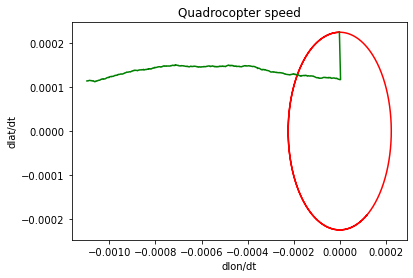

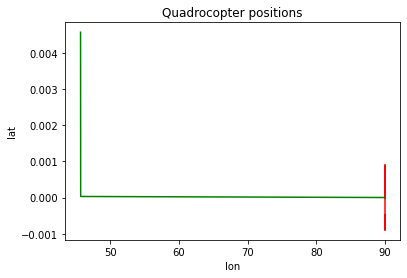

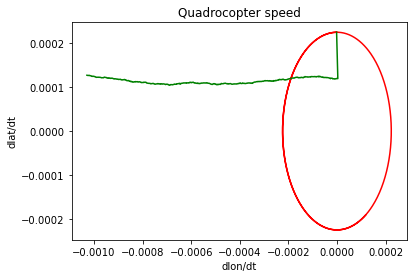

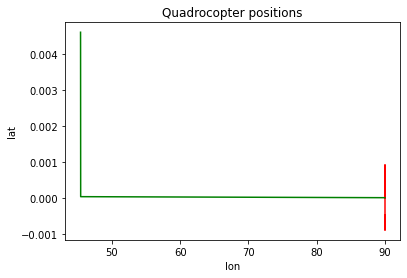

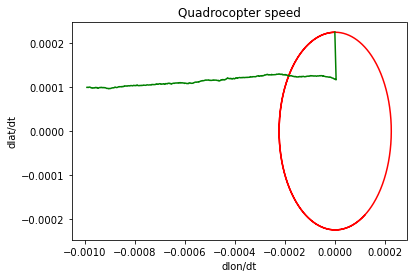

In [21]:
# рассматриваем влияние шума на примере окружности
pnum = 1000
mult = 0.1
#
noise_val = [0.1, 0.1]
t, Z, Y, Y_noise, random_shifts_devs, scales = test_model_circle(noise_val)
show(t, Z, Y_noise, pnum, scales, mult * random_shifts_devs)
#
noise_val = [0.4, 0.4]
t, Z, Y, Y_noise, random_shifts_devs, scales = test_model_circle(noise_val)
show(t, Z, Y_noise, pnum, scales, mult * random_shifts_devs)
#
noise_val = [0.8, 0.8]
t, Z, Y, Y_noise, random_shifts_devs, scales = test_model_circle(noise_val)
show(t, Z, Y_noise, pnum, scales, mult * random_shifts_devs)

### Шум процесса

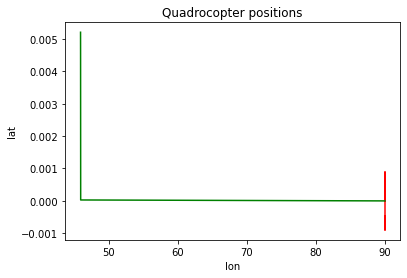

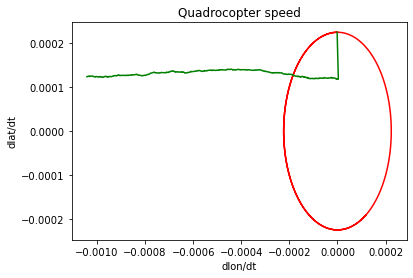

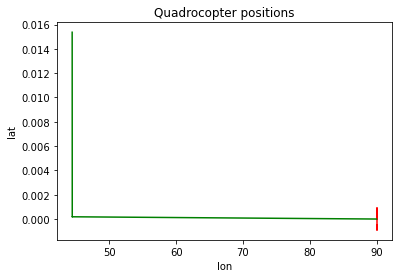

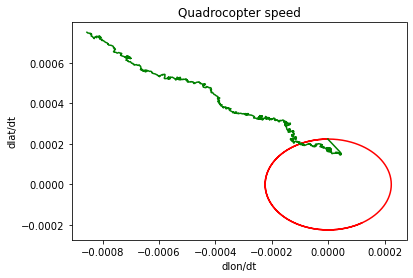

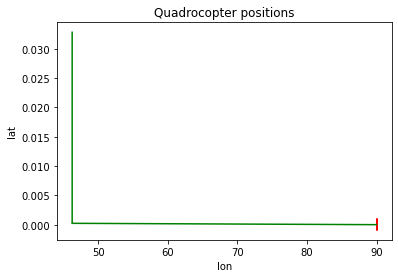

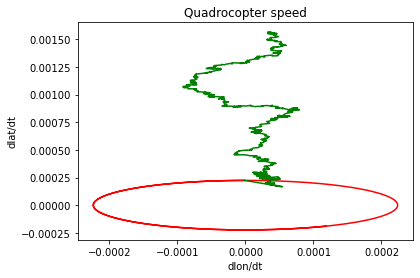

In [22]:
# рассматриваем влияние шума на примере окружности
pnum = 1000
noise_val = [0.1, 0.1]
#
mult = 0.1
t, Z, Y, Y_noise, random_shifts_devs, scales = test_model_circle(noise_val)
show(t, Z, Y_noise, pnum, scales, mult * random_shifts_devs)
#
mult = 0.8
t, Z, Y, Y_noise, random_shifts_devs, scales = test_model_circle(noise_val)
show(t, Z, Y_noise, pnum, scales, mult * random_shifts_devs)
#
mult = 1.0
t, Z, Y, Y_noise, random_shifts_devs, scales = test_model_circle(noise_val)
show(t, Z, Y_noise, pnum, scales, mult * random_shifts_devs)

## 5. Устойчивость решения
Из полученных результатов видно, что фильтр частиц крайне неустойчив (о влиянии шумов говорить не приходится, так как даже на чистых данных сложно настроить фильтр на какой-нибудь результат).

## 6. Сравнение фильтров
Мне не удалось добиться какого-то результата с фильтром частиц. В то же время фильтр Калмана давал неплохие результаты на чистых, а также на слабо зашумлённых данных.